In [1]:
!pip install --upgrade albumentations
!nvidia-smi

Fri Jul 23 15:59:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
from copy import deepcopy

%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

# torch.backends.cudnn.benchmark = True

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
type(train_set.data), type(train_set.targets)

(numpy.ndarray, list)

In [7]:
# calculate mean and standard deviation

mean = np.mean(train_set.data, axis=(0,1,2))


sdev = np.std(train_set.data, axis=(0, 1, 2))


In [8]:
mean.shape

(3,)

In [9]:
mean = mean/255
sdev = sdev/255

In [10]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [15]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [17]:
# taken from : https://github.com/jackryo/ricap/blob/master/utils.py
def apply_ricap(*, batch, beta=0.3):

    input, target = batch

    I_x, I_y = input.size()[2:]

    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}

    for k in range(4):
        idx = torch.randperm(input.size(0))
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = target[idx].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat(
        (torch.cat((cropped_images[0], cropped_images[1]), 2),
         torch.cat((cropped_images[2], cropped_images[3]), 2)),
        3)

    patched_images = patched_images.cuda()
    
    return patched_images, W_, c_

In [18]:
lr_epochs = []

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def train(model, device, train_loader, optimizer, scheduler,
          criterion, train_acc, train_loss, epoch, ricap_apply=False,
          ricap_beta=0.1, ricap_stop_epoch=15, end_lr_factor=0.1,
          end_cycle_lr_epoch=21, to_reduce_times=1):   
    
    def update_end_lr():
        global reduced_count
        if reduced_count < to_reduce_times :
            reduced_count += 1
            print(f"ending lr reduced: {reduced_count} times")
            # lr = optimizer.param_groups[0]['lr']
            for grp in optimizer.param_groups:
                grp['lr'] = grp['lr'] * end_lr_factor
            

    if epoch >= end_cycle_lr_epoch:
        update_end_lr()

    model.train()
    
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    ricap = False
    acc = 0.
    lr_epochs.append((epoch, optimizer.param_groups[0]['lr']))
    print(f"\nEpoch num: {epoch}  |  LR: {optimizer.param_groups[0]['lr']:.10f}", end="\n")

    for batch_idx, (data, target) in enumerate(pbar):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        if ricap_apply is True and epoch < ricap_stop_epoch:
            data, W_, c_ = apply_ricap(batch=(data, target), beta=ricap_beta)
            y_pred = model(data)
            loss = sum([W_[k] * criterion(y_pred, c_[k]) for k in range(4)])
            acc = sum([W_[k] * accuracy(y_pred, c_[k])[0] for k in range(4)]).item()
        else:
            y_pred = model(data)
            loss = criterion(y_pred, target)  
        
        loss.backward()
        optimizer.step()

        if epoch < end_cycle_lr_epoch:
            scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        acc = 100 * correct / processed if not ricap_apply else acc
        pbar.set_description(desc=f'Loss={loss.item()} Accuracy={acc:.2f}')
    train_loss.append(loss.data.cpu().numpy().item())
    train_acc.append(100 * correct / processed) 

In [19]:
def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.5f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [21]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [22]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [25]:
# transforms
# cutout p: 0.5 -> 0.4 -> 0.2 -> 
# scshrt: 0.2-> 
# jitter: 0.1 -> 0.2
var = (0.247+0.243+0.261)/3**2
train_transforms = A.Compose([     
                    A.Sequential([
                    A.CropAndPad(px=4, keep_size=False),
                    A.RandomCrop(32,32)]),
                    A.HorizontalFlip(p=0.58),
                    A.CoarseDropout(p=0.81, max_holes = 1, min_holes=1, max_height=8, max_width=8,
                                    fill_value=(0.4914, 0.4822, 0.4465)),
                    A.GaussNoise(mean=mean, p=0.3,var_limit=var*2),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                    ToTensorV2()
                    ])

test_transforms = A.Compose([
                  A.HorizontalFlip(p=1),
                  A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                  ToTensorV2()
                ])

In [26]:
# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

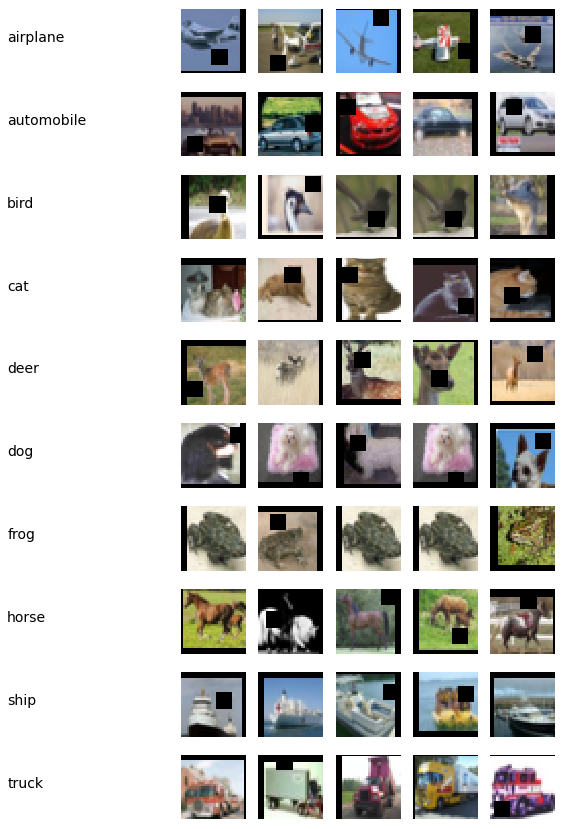

In [27]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [29]:
# re-write
conv3x3 = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
bn_momentum = 0.3

class CustomResNet(nn.Module): 
    def __init__(self):
        super().__init__()
        self.prep = nn.Sequential(
            conv3x3(3, 64, 3, padding=1), 
            bn(64,momentum=bn_momentum,),
            nn.ReLU(True)
            )

        self.layer1 = nn.Sequential(
            conv3x3(64, 128, 3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(128,momentum=bn_momentum),
            nn.ReLU(True)
            )

        self.res1 = nn.Sequential(
            conv3x3(128, 128, 3, padding=1), 
            bn(128,momentum=bn_momentum),
            nn.ReLU(True),
            conv3x3(128, 128, 3, padding=1), 
            bn(128,momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.layer2 =  nn.Sequential(
            conv3x3(128, 256,3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(256,momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.layer3 = nn.Sequential(
            conv3x3(256, 512, 3, padding=1), 
            nn.MaxPool2d(2, 2),
            bn(512,momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.res3 = nn.Sequential(
            conv3x3(512, 512, 3, padding=1), 
            bn(512,momentum=bn_momentum),
            nn.ReLU(True),
            conv3x3(512, 512, 3, padding=1),
            bn(512,momentum=bn_momentum),
            nn.ReLU(True)
        )

        self.final_max = nn.MaxPool2d(4)
        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

    def forward(self, x):

        prep = self.prep(x)

        layer1 = self.layer1(prep)
        res1 = self.res1(layer1)
        layer1 = layer1 + res1

        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        res3 = self.res3(layer3)
        layer3 = layer3 + res3

        max = self.final_max(layer3)
        out = max.view(max.size(0),-1)

        out = self.fc(out)

        return out * 0.175 # credit goes to David Page, I am just trying it out, need to figure out how he figured out `0.125` value and effects with BN and image aug

In [30]:
model = CustomResNet().to(device)

criterion = LabelSmoothingCrossEntropy(smoothing=0.2)

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [31]:
# criterion = nn.CrossEntropyLoss()

model = CustomResNet().to(device)

# pct: 0.18 -> 0.2 -> 0.24
# lr -> 0.032 -> 0.038 -> 0.04

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.49, total_steps=None,
                                          pct_start=0.2, anneal_strategy='linear',
                                          epochs=24, steps_per_epoch=len(train_loader),
                                          div_factor=10.0,final_div_factor=1, cycle_momentum=False)#, max_momentum=0.9)

LR = []
lr_epochs = []
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
reduced_count = 0

# train method only applies RICAP if epoch < 15 and ricap_apply flag is set to True
ricap_apply_prob = -1
ricap=False

for epoch in range(24):
    LR.append(optimizer.param_groups[0]['lr'])
    
    if ricap_apply_prob > np.random.random() and epoch < 10:
        ricap = True
        print(f"\nApplying RICAP at epoch: {epoch+1}")
    else:
        ricap = False
    
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy,
          train_losses, epoch+1,
          ricap_apply=ricap, ricap_beta=0.27,
          end_cycle_lr_epoch=21 ,end_lr_factor=0.47, to_reduce_times=3)
    
    test(model, device, test_loader,test_accuracy, test_losses)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 1  |  LR: 0.0490000000


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00233, Accuracy: 6104/10000 (61.040%)


Epoch num: 2  |  LR: 0.1410707286


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00199, Accuracy: 6735/10000 (67.350%)


Epoch num: 3  |  LR: 0.2331414572


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00168, Accuracy: 7572/10000 (75.720%)


Epoch num: 4  |  LR: 0.3252121858


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00141, Accuracy: 8104/10000 (81.040%)


Epoch num: 5  |  LR: 0.4172829144


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00140, Accuracy: 8082/10000 (80.820%)


Epoch num: 6  |  LR: 0.4851718750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00126, Accuracy: 8217/10000 (82.170%)


Epoch num: 7  |  LR: 0.4622031250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00122, Accuracy: 8382/10000 (83.820%)


Epoch num: 8  |  LR: 0.4392343750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00128, Accuracy: 8365/10000 (83.650%)


Epoch num: 9  |  LR: 0.4162656250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00119, Accuracy: 8516/10000 (85.160%)


Epoch num: 10  |  LR: 0.3932968750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00114, Accuracy: 8624/10000 (86.240%)


Epoch num: 11  |  LR: 0.3703281250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00114, Accuracy: 8617/10000 (86.170%)


Epoch num: 12  |  LR: 0.3473593750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00114, Accuracy: 8666/10000 (86.660%)


Epoch num: 13  |  LR: 0.3243906250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00112, Accuracy: 8796/10000 (87.960%)


Epoch num: 14  |  LR: 0.3014218750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00110, Accuracy: 8803/10000 (88.030%)


Epoch num: 15  |  LR: 0.2784531250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00113, Accuracy: 8654/10000 (86.540%)


Epoch num: 16  |  LR: 0.2554843750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00100, Accuracy: 8904/10000 (89.040%)


Epoch num: 17  |  LR: 0.2325156250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00100, Accuracy: 8895/10000 (88.950%)


Epoch num: 18  |  LR: 0.2095468750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00095, Accuracy: 9005/10000 (90.050%)


Epoch num: 19  |  LR: 0.1865781250


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00093, Accuracy: 8997/10000 (89.970%)


Epoch num: 20  |  LR: 0.1636093750


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00097, Accuracy: 8966/10000 (89.660%)

ending lr reduced: 1 times

Epoch num: 21  |  LR: 0.0661010938


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00082, Accuracy: 9252/10000 (92.520%)

ending lr reduced: 2 times

Epoch num: 22  |  LR: 0.0310675141


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00078, Accuracy: 9343/10000 (93.430%)

ending lr reduced: 3 times

Epoch num: 23  |  LR: 0.0146017316


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.00076, Accuracy: 9360/10000 (93.600%)


Epoch num: 24  |  LR: 0.0146017316


Loss=0.9179843664169312 Accuracy=98.25: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s]



Test set: Average loss: 0.00075, Accuracy: 9376/10000 (93.760%)



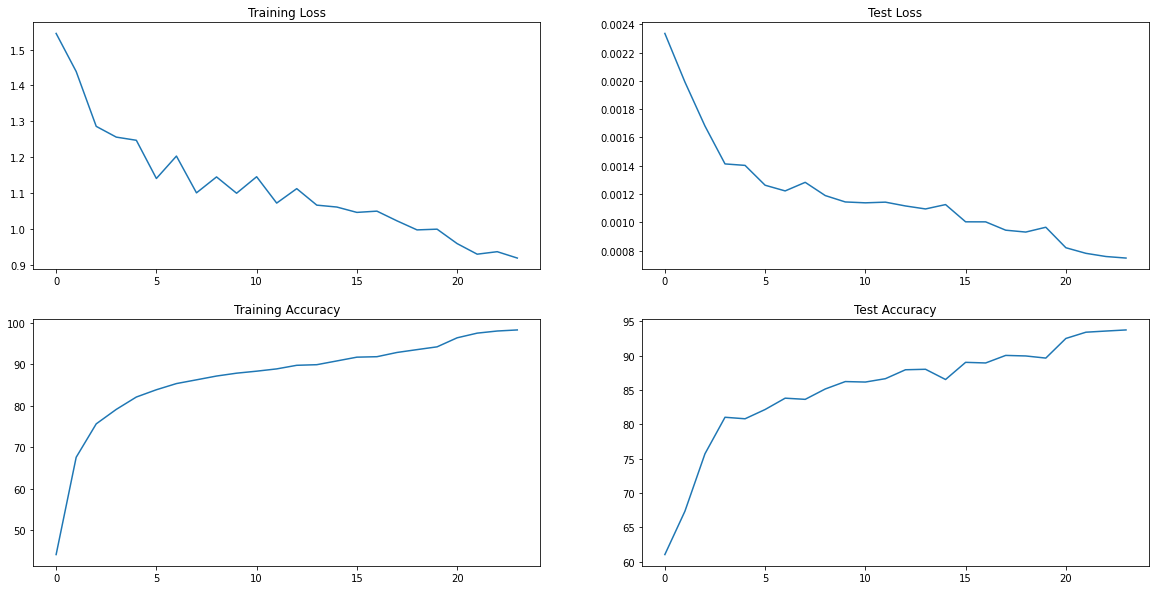

In [32]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)   

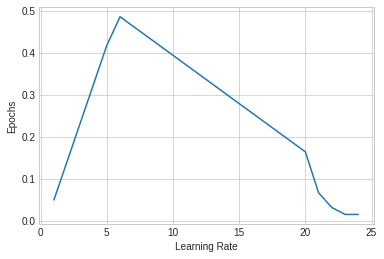

In [33]:
x, y = [x for x, y in lr_epochs], [y for x, y in lr_epochs]
plt.style.use('seaborn-whitegrid')
plt.plot(x, y)
plt.ylabel('Epochs')
plt.xlabel('Learning Rate')
plt.show()